In [1]:
import pandas as pd
import numpy as np
import pyarrow
import statsmodels.api as sml

# contract path
contract_path = r"C:\Users\jaman\OneDrive\futures_data\contract_data.parquet"
contract_data = pd.read_parquet(contract_path, engine='pyarrow')

# ticker master
ticker_master_path = r"C:\Users\jaman\OneDrive\futures_data\ticker_master.csv"
ticker_master_data = pd.read_parquet(contract_path, engine='pyarrow')

#universe path
universe_path = r'C:\Users\jaman\OneDrive\futures_data\futures_universe.xlsx'

# universe
UNIVERSE = pd.read_excel(universe_path)
UNIVERSE

,futures_market_name,future
0,10-Year Govt. of Canada Bond,CGB
1,10-Year U.S. T-Note,ZN
2,2-Year U.S. T-Note,ZT
3,5-Year U.S. T-Note,ZF
4,ASX 10 Year Treasury Bond,YXT
...,...,...
67,Swiss Franc,6S
68,Swiss Market Index,FSMI
69,U.S. T-Bond,ZB
70,White Sugar,LSU


In [27]:
len(UNIVERSE)

72

**Forward Roll of a Single Futures Contact, and data processing for all futures contracts**

Methodology for all futures. Instead of having to pick which contract to roll forward for each market we can do the following

1) Calculate the daily returns for all contracts across all markets on each date (t1-t0)/t0
2) For each future find the ticker that has the largest traded volume on each date
3) Re-index entire dataset, this should result in just one future and one ticker for each date
4) Create total return indices for each unique future, assuming we trade the most liquid contract every day
5) The result is a single time-series for each future similar to the price of a stock 
** 

In [2]:
import matplotlib.pyplot as plt


def build_full_dataset(contract_data, dropNaN=True):
    """
    This methodology assumes we always trade the active contract at the close.
    Active contract is determined by the contract with highest volume
    """
    contract_data = contract_data.copy()

    # grab the master index
    master_idx = contract_data.groupby(by=['date', 'future']).volume.idxmax()

    # compute returns
    returns = contract_data.droplevel([1])[['close']].unstack().pct_change(periods=1, fill_method=None).stack()
    returns=returns.reset_index()
    print(returns.columns)
    returns.rename(columns={'close': 'ret'}, inplace=True)

    # contract data
    contract_data.reset_index(inplace=True)
    contract_data = contract_data.merge(returns, how="left",
                                        left_on=['date', 'ticker'],
                                        right_on=['date', 'ticker'])
    
    # now we can drop the ticker level
    contract_data.set_index(['date', 'future', 'ticker'], inplace=True)
    contract_data = contract_data.reindex(master_idx.values) # reindex!
    contract_data.sort_index(inplace=True)

    return contract_data


def get_roll_gaps(future: pd.DataFrame):
    """
    Implements the forward roll of a single futures contract. For example ES depth=1
    """

    # single future contract (constant depth)
    future = future.copy()
    
    # find roll dates
    roll_dates = future[['security_name']].drop_duplicates(keep='first').index
    roll_dates = roll_dates[1:-1]
    
    # find date one day prior to roll dates
    one_day_before_roll = [future.iloc[future.index.get_loc(i)-1].name for i in roll_dates]
    one_day_before_roll=sorted(one_day_before_roll)

    # find and fill the gaps
    gaps = future['close'] * 0
    gaps.loc[roll_dates] = future['open'].loc[roll_dates] - future['close'].loc[one_day_before_roll].values

    # gaps need to rollforward to future prices
    gaps = gaps.cumsum()

    # post processing
    # Subtract the gaps series from prices
    # gaps=get_roll_gaps(es)
    # rolled = es.copy()
    # rolled['close'] -=gaps

    # es = contract_data.loc[(contract_data['futures_market_name']=='E-mini S&P 500') & (contract_data.depth==1)].copy()
    # es = es.droplevel([1, 2])

    # rolled['Returns'] = rolled['close'].diff()/rolled['close'].shift(1)
    # rolled['rPrices'] = (1+rolled['Returns']).cumprod()

    # rolled['rPrices'].plot(title='forward roll ES depth=1')
    # plt.xticks(rotation=45)

    return gaps


# full dataset
full_dataset = build_full_dataset(contract_data)

def build_total_return_index(full_dataset):
    # post 1990-01-01 like in the paper
    full_dataset = full_dataset.droplevel([2])
    most_recent = full_dataset.loc[full_dataset.index.get_level_values('date')>='1990-01-01']

    # now apply our universe
    unique_futures_universe = UNIVERSE.future.to_list()

    # filter on just the unique futures market names
    most_recent = most_recent.loc[most_recent.index.get_level_values('future').isin(unique_futures_universe)]

    # grab the TR index
    tr_index = most_recent[['ret']].unstack()
    tr_index=(1 + tr_index).cumprod()

    # fillNaNs forward , should only be some weekend dates for certain futures with a fill limit of 5 on the columns
    tr_index = tr_index.fillna(method='ffill', limit=5, axis=0).stack()
    return tr_index




Index(['date', 'ticker', 'close'], dtype='object')


**Example of creating the total return index for each futures contract with a starting date of 1990-01-01**

In [3]:
# droplevel on the full dataset
full_dataset = full_dataset.droplevel([2])

# post 1990-01-01 like in the paper
most_recent = full_dataset.loc[full_dataset.index.get_level_values('date')>='1990-01-01']

# now apply our universe
unique_futures_universe = UNIVERSE.future.to_list()

# filter on just the unique futures market names
most_recent = most_recent.loc[most_recent.index.get_level_values('future').isin(unique_futures_universe)]

# grab the TR index
tr_index = most_recent[['ret']].unstack()
tr_index=(1 + tr_index).cumprod()


In [4]:
# fill NaNs forward
tr_index = tr_index.fillna(method='ffill', limit=5, axis=0).stack()
tr_index.tail()
tr_index.to_parquet(r"C:\Users\jaman\OneDrive\futures_data\future_total_return_index.parquet")

In [24]:
tr_index.unstack().shape

(8765, 72)

In [26]:
tr_index

ret
date       future          
1990-01-02 6A      0.992526
           6B      0.996601
           6C      0.998598
           6J      0.982635
           6S      0.972814
...                     ...
2023-09-15 ZO      1.494633
           ZR      0.108847
           ZS      3.981071
           ZT      1.411687
           ZW      0.087970

[570491 rows x 1 columns]

**Benchmark Models From the Paper - MACD Sign and Exponentially Weighted, linear trend model**

**Time-series momentum strategy (TSMOM) Moskowitz et al. 2012 [1] - Page 4 of Deep Momentum Networks Paper** 
**take the sign of trailing 252-d returns**


**MACD trend estimation Baz et al. 2015 [4] - Page 4 of Deep Momentum Networks Paper**


In [5]:
def tVarLinR(close: pd.Series) -> float:
    # a series of closing prices
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(np.log(close), x).fit()
    return ols.tvalues[1]

def linear_trend_estimator(rolled: pd.DataFrame, roll_col: str, look_back=252):
    # rolled
    rolled = rolled.copy()
    rolled[f'signal_{look_back}'] = rolled[roll_col].rolling(look_back).apply(lambda x: tVarLinR(x))
    rolled[f'size_{look_back}'] = np.sign(rolled[f'signal_{look_back}'])
    return rolled[[roll_col, f'signal_{look_back}', f'size_{look_back}']]

def tsmom_single_future(rolled:pd.DataFrame, roll_col:str, look_back=252):
    # don't modify original
    rolled = rolled.copy()
    rolled[f'signal_{look_back}'] = rolled[roll_col].pct_change(look_back)
    rolled[f'size_{look_back}'] = np.sign(rolled[f'signal_{look_back}'])
    return rolled[[roll_col, f'signal_{look_back}', f'size_{look_back}']]

def macd_trend_estimator(rolled:pd.DataFrame, roll_col:str, macd_params:list=[[8, 24], [16, 48], [32, 96]], position_size='exp'):
    # copy the rolled data
    rolled = rolled.copy()

    for mcd_p in macd_params:
        # difference between moving averages
        rolled[f'macd_{mcd_p[0]}_{mcd_p[1]}'] = (rolled[roll_col].ewm(span=mcd_p[0]).mean() - rolled[roll_col].ewm(span=mcd_p[1]).mean())/rolled[roll_col].rolling(63).std()

    # create macd index
    macd_cols = [x for x in rolled.columns if x.startswith('macd')]

    # equally weighted index
    rolled['macd_index'] = rolled[macd_cols].mean(axis=1)

    # now normalize by z
    rolled['signal_macd'] = rolled['macd_index'] / rolled['macd_index'].ewm(252).std()

    if position_size == 'exp':
        rolled['size_macd'] = (rolled['signal_macd'] * (np.exp(-rolled['signal_macd']**2/4)))/.89
    else:
        rolled['size_macd'] = np.sign(rolled['signal_macd'])

    return rolled[[roll_col, 'signal_macd', 'size_macd']]

def compute_strat_returns(signals:pd.DataFrame, roll_col: str):
    # don't modify
    signals = signals.copy()
    signal_col = [x for x in signals if x.startswith('signal')]
    signal_col = signal_col[0]

    # size column
    size_col = [x for x in signals if x.startswith('size')]
    size_col = size_col[0]

    # these are the signals
    signals['ret'] = signals[roll_col].pct_change()

    # shift size and signal column back one day, so we can evalute the return holding a position long over the following day
    signals[signal_col] = signals[signal_col].shift(1)
    signals[size_col] = signals[size_col].shift(1)

    # compute profit and loss of strategy 
    signals['strategy_returns'] = signals[size_col] * signals['ret']
    signals['strategy_cumulative_returns'] = (1+signals['strategy_returns']).cumprod()
    signals.dropna(inplace=True)
    return signals


    

**Time-Series Momentum Benchmark (TSMOM)**

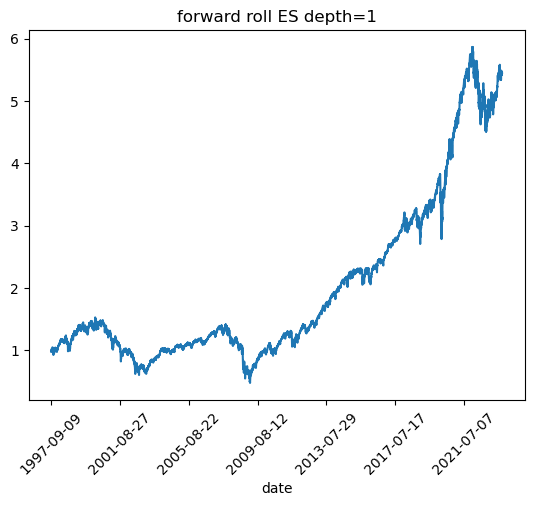

In [6]:
# Bring in the data
#post processing
#Subtract the gaps series from prices
es = contract_data.loc[(contract_data['futures_market_name']=='E-mini S&P 500') & (contract_data.depth==1)].copy()
es = es.droplevel([1, 2])
gaps=get_roll_gaps(es)
rolled = es.copy()
rolled['close'] -=gaps
rolled['Returns'] = rolled['close'].diff()/rolled['close'].shift(1)
rolled['rPrices'] = (1+rolled['Returns']).cumprod()

rolled['rPrices'].plot(title='forward roll ES depth=1')
plt.xticks(rotation=45)


tsmom=tsmom_single_future(rolled, 'rPrices', 252)
tsmom_returns = compute_strat_returns(tsmom, 'rPrices')

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2019-09-26'),
  Text(0.0, 0, '1998-09-11'),
  Text(1000.0, 0, '2002-09-05'),
  Text(2000.0, 0, '2006-08-24'),
  Text(3000.0, 0, '2010-08-13'),
  Text(4000.0, 0, '2014-07-31'),
  Text(5000.0, 0, '2018-07-19'),
  Text(6000.0, 0, '2022-07-11'),
  Text(7000.0, 0, '')])

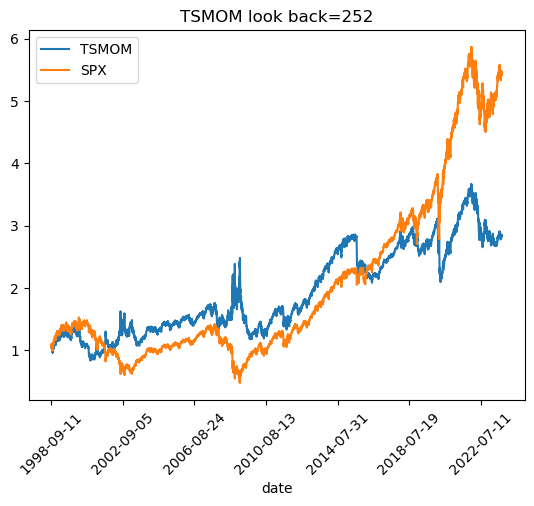

In [7]:
tsmom_returns[['strategy_cumulative_returns']].plot(title='TSMOM look back=252')
plt.plot(tsmom_returns['rPrices'])
plt.legend(['TSMOM', 'SPX'])
plt.xticks(rotation=45)

**MACD Benchmark , Binary and Exponentiated Position Sizes**

In [8]:
macd1 = macd_trend_estimator(rolled, 'rPrices', position_size='binary')
macd2 = macd_trend_estimator(rolled, 'rPrices', position_size='exp')

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2019-09-26'),
  Text(0.0, 0, '1997-12-10'),
  Text(1000.0, 0, '2001-12-04'),
  Text(2000.0, 0, '2005-11-22'),
  Text(3000.0, 0, '2009-11-12'),
  Text(4000.0, 0, '2013-10-29'),
  Text(5000.0, 0, '2017-10-17'),
  Text(6000.0, 0, '2021-10-07'),
  Text(7000.0, 0, '')])

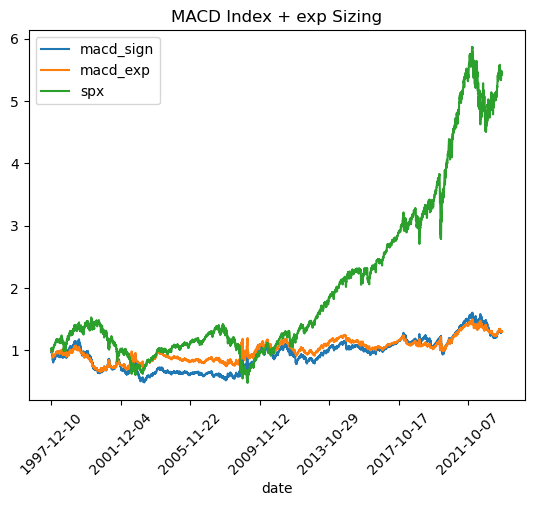

In [9]:
macd_returns1 = compute_strat_returns(macd1, 'rPrices')
macd_returns2 = compute_strat_returns(macd2, 'rPrices')
macd_returns1[['strategy_cumulative_returns']].plot(title='MACD Index + exp Sizing')
plt.plot(macd_returns2.strategy_cumulative_returns.values)
plt.plot(macd_returns2['rPrices'])
plt.legend(['macd_sign', 'macd_exp', 'spx'])
plt.xticks(rotation=45)

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2019-09-26'),
  Text(0.0, 0, '1998-09-10'),
  Text(1000.0, 0, '2002-09-04'),
  Text(2000.0, 0, '2006-08-23'),
  Text(3000.0, 0, '2010-08-12'),
  Text(4000.0, 0, '2014-07-30'),
  Text(5000.0, 0, '2018-07-18'),
  Text(6000.0, 0, '2022-07-08'),
  Text(7000.0, 0, '')])

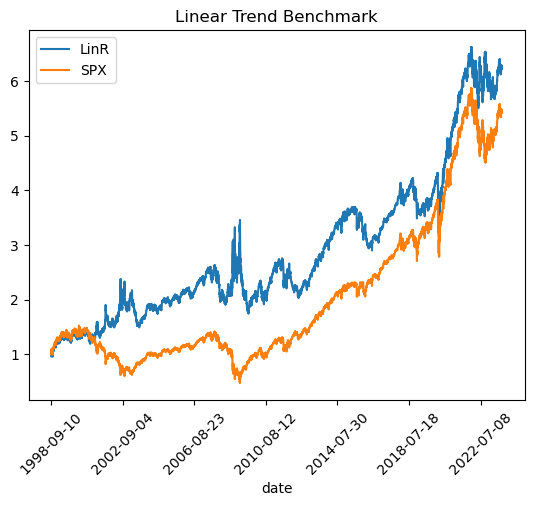

In [10]:
# linear trend
linear_trend = linear_trend_estimator(rolled, 'rPrices', 252)
linear_trend_returns = compute_strat_returns(linear_trend, 'rPrices')
linear_trend_returns[['strategy_cumulative_returns']].plot(title='Linear Trend Benchmark')
plt.plot(linear_trend_returns['rPrices'])
plt.legend(['LinR', 'SPX'])
plt.xticks(rotation=45)

